In [74]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-rating/100k_imdb_ratings_filled.csv
/kaggle/input/movie-ratings-test/movie_ratings-1.csv
/kaggle/input/movie-ratings-test-genres/movie_genres-1.csv
/kaggle/input/movielens-100k-dataset/ml-100k/u.occupation
/kaggle/input/movielens-100k-dataset/ml-100k/u1.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.info
/kaggle/input/movielens-100k-dataset/ml-100k/u4.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.item
/kaggle/input/movielens-100k-dataset/ml-100k/README
/kaggle/input/movielens-100k-dataset/ml-100k/u1.test
/kaggle/input/movielens-100k-dataset/ml-100k/ua.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.data
/kaggle/input/movielens-100k-dataset/ml-100k/u5.test
/kaggle/input/movielens-100k-dataset/ml-100k/mku.sh
/kaggle/input/movielens-100k-dataset/ml-100k/u5.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.user
/kaggle/input/movielens-100k-dataset/ml-100k/ub.base
/kaggle/input/movielens-100k-dataset/ml-100k/u4.base
/kaggle/input/movielens-100k-dataset/ml

In [75]:
# Load user, ratings, and movie data
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    '/kaggle/input/movielens-100k-dataset/ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    '/kaggle/input/movielens-100k-dataset/ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Add input query here

In [76]:
# 0-index data
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [77]:
new_user_data = pd.read_csv("/kaggle/input/movie-ratings-test/movie_ratings-1.csv")

In [78]:
new_user_data["movie_id"] = new_user_data["movie_name"].apply(lambda x: movies[movies["title"] == x].iloc[0]["movie_id"])
new_user_data["user_id"] = max(ratings["user_id"].astype(int))+1
new_user_data["unix_timestamp"] = 0
new_user_data = new_user_data[new_user_data["rating"] != "Didn't watch"]

In [79]:
ratings = ratings.append(pd.DataFrame({"user_id": new_user_data["user_id"], "movie_id": new_user_data["movie_id"], "rating": new_user_data["rating"].astype(float), "unix_timestamp": new_user_data["unix_timestamp"]}), ignore_index=True)

# Preprocessing

# Begin here

In [80]:
ratings['movie_id'] = ratings['movie_id'].values.astype(int)
ratings['user_id'] = ratings['user_id'].values.astype(int)

Let's try using the matrix factorization model in order to find user and movie embeddings.
First step is to create the rating matrix. Should use a sparse matrix to do this.

In [81]:
indices = []
values = []
for row in ratings.iterrows():
    indices.append([int(row[1]["user_id"]), int(row[1]["movie_id"])])
    values.append(int(row[1]["rating"]))

train_ratings_sparse = tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=[max(ratings["user_id"].unique())+1, max(ratings["movie_id"].unique())+1])


Next step is to create the embeddings. These are the variables which are to be modified to reduce the mse.

In [82]:
embedding_dimension = 50
num_users = max(ratings["user_id"].unique())+1
num_movies = max(ratings["movie_id"].unique())+1

user_embeddings = tf.Variable(tf.random.normal([num_users, embedding_dimension]))
movie_embeddings = tf.Variable(tf.random.normal([num_movies, embedding_dimension]))

In [83]:
predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      train_ratings_sparse.indices)
predictions = tf.where(train_ratings_sparse.values == 0, tf.zeros_like(predictions), predictions)
error = tf.losses.mean_squared_error(train_ratings_sparse.values, predictions)

Training process

In [84]:
optimizer = tf.train.GradientDescentOptimizer(10.)
minimize_op = optimizer.minimize(error)

Final MSE: 0.385111540555954 with 1000 iterations


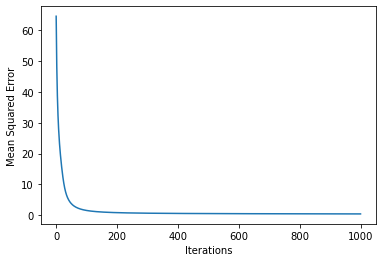

In [85]:
session = tf.Session()
session.run(tf.initialize_all_variables())
num_iterations = 1000
results = []
for iteration in range(num_iterations):
    _, a = session.run((minimize_op, {"error": error}))
    results.append(a["error"])

import matplotlib.pyplot as plt
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.plot(results)
print("Final MSE: {} with {} iterations".format(results[-1], len(results)))

In [86]:
test_user_id = max(ratings["user_id"])
user_embeddings_np = session.run(user_embeddings)
query = user_embeddings_np[test_user_id]
scores = [np.dot(query, user_embeddings_np[i]) for i in range(len(user_embeddings_np))]
scores = [scores[i]/(np.linalg.norm(query)*np.linalg.norm(user_embeddings_np[i])) for i in range(len(user_embeddings_np))]

In [87]:
scores = list(zip([i for i in range(len(scores))], scores))
scores.sort(key=lambda x: x[1], reverse=True)

Sort by user similarity and pick users who value at least 2/3 of the categories the same way our user does.
Hmm, maybe another idea would be to pick users who DON'T value the categories the same way the user does but is also similar to them in terms of the embeddings. This way, we get movie recs from a similar user but one who likes a movie from a certain category even if they don't like that category.

In [88]:
genres = pd.read_csv("/kaggle/input/movie-ratings-test-genres/movie_genres-1.csv")["genre"]

Load rating data into ratings df

In [89]:
imdb_ratings = pd.read_csv("/kaggle/input/imdb-rating/100k_imdb_ratings_filled.csv")
ratings["imdb"] = ratings["movie_id"].apply(lambda x: imdb_ratings.iloc[x]["imdb_user_rating"]/2)

First, find users that value these genres as much as our user. The way we do this is by check their ratings relative to imbd ratings for that movie.

In [90]:
for genre in genres:
    ratings[genre] = ratings["movie_id"].apply(lambda x: movies.iloc[x][genre])


In [91]:
type(ratings["rating"].iloc[-1])

numpy.float64

In [92]:
ratings["above"] = (ratings["imdb"] > ratings["rating"])
ratings["above"] = ratings["above"].apply(lambda x: int(x))

PLOT PERCENTAGE OF TIMES MOVIES FROM EACH GENRE ARE RATED BY USERS ABOVE THE IMDB RATING (FOR REPORT)

In [93]:
data = {}
for col in genres:
    data[col] = sum(ratings.apply(lambda x: x[col] and x["above"], axis=1))/len(ratings[ratings[col] == 1])*100

In [146]:
# del data["genre_unknown"]

In [ ]:
import matplotlib.pyplot as plt

plt.xticks(rotation=90)
plt.bar(data.keys(), data.values())

In [99]:
def func1(x):
    if x[genres[0]] == 1:
        return x["above"]
    return -1
def func2(x):
    if x[genres[1]] == 1:
        return x["above"]
    return -1
def func3(x):
    if x[genres[2]] == 1:
        return x["above"]
    return -1
# for genre in genres:
ratings[genres[0]+"_above"] = ratings.apply(func1, axis=1)
ratings[genres[1]+"_above"] = ratings.apply(func2, axis=1)
ratings[genres[2]+"_above"] = ratings.apply(func3, axis=1)

In [139]:
THRESHOLD_COUNT = 25
group_by_percentage = ratings.groupby(["user_id"])
def percentage_genre(user_id, genre):
    data = group_by_percentage.get_group(user_id)
    v = data[genre+"_above"].value_counts()
    if 1 not in v:
        if 0 not in v:
            return 1
        if v[0] < THRESHOLD_COUNT:
            return 1
        return 0
    if 0 not in v:
        # Used liked all from this genre
        return 1
    if v[0]+v[1] < THRESHOLD_COUNT:
        # Signalling 100% liking just to make us ignore this user for this category
        return 1
    return (v[1]/(v[0]+v[1]))

def get_random_movie_genre(user_id, genre):
    data = group_by_percentage.get_group(user_id)
    genre_data = data[data[genre] == 1]
    high_rated = genre_data[genre_data["rating"] == 5]
    if len(high_rated) == 0:
        return None
    return high_rated.sample()["movie_id"].iloc[0]

def get_movie(movie_id):
    return movies[movies["movie_id"] == str(movie_id)]["title"].iloc[0]

In [141]:
import random

original_user_movies_df = pd.read_csv("/kaggle/input/user-data-matrix/Movielens.csv")
original_user_movies_temp = original_user_movies_df.columns[1:-2]
original_user_movies = []
for movie in original_user_movies_temp:
    if original_user_movies_df[movie].iloc[0] != "Didn't watch":
        original_user_movies.append(movie)
recommendations = []
MAX_PERCENTAGE_THRESHOLD = 0.4
NUM_RECS_TO_MAKE = 5
i = 0
for score in scores[1:]:
    user_id = score[0]
    random_genre = random.choice(genres)
    random_movie = get_random_movie_genre(user_id, random_genre)
    if random_movie is not None and random_movie not in recommendations and get_movie(random_movie) not in original_user_movies:
        recommendations.append(random_movie)
    if len(recommendations) == 5:
        break
    

In [142]:
for i in range(len(recommendations)):
    print(movies.iloc[recommendations[i]]["title"])

Wizard of Oz, The (1939)
Evita (1996)
Babe (1995)
Nightmare Before Christmas, The (1993)
Akira (1988)


In [144]:
original_user_movies_df = pd.read_csv("/kaggle/input/user-data-matrix/Movielens.csv")
original_user_movies_temp = original_user_movies_df.columns[1:-2]
original_user_movies = []
for movie in original_user_movies_temp:
    if original_user_movies_df[movie].iloc[0] != "Didn't watch":
        original_user_movies.append(movie)
recommendations = []
MAX_PERCENTAGE_THRESHOLD = 0.4
NUM_RECS_TO_MAKE = 5

for score in scores[1:]:
    user_id = score[0]
    for genre in genres:
        if percentage_genre(user_id, genre) < MAX_PERCENTAGE_THRESHOLD:
            random_movie = get_random_movie_genre(user_id, genre)
            if random_movie is not None and random_movie not in recommendations and get_movie(random_movie) not in original_user_movies:
                recommendations.append(random_movie)
            if len(recommendations) == 5:
                break
                
    if len(recommendations) == 5:
        break
    

In [145]:
for i in range(len(recommendations)):
    print(movies.iloc[recommendations[i]]["title"])

Beauty and the Beast (1991)
Lion King, The (1994)
Alice in Wonderland (1951)
20,000 Leagues Under the Sea (1954)
Hunchback of Notre Dame, The (1996)


**Just tried some random stuff below this.... Not part of the final model or recommendations.**

Add another "movie" that every user rates 1 to 5. 1 would mean that they disagree with traditional imdb ratings and 5 would mean they agree. Should we do disagreement or absolute placement (i.e. 0 if below, 1 if above or something). Put these in the result matrix and add one row for movie column....

In [ ]:
imdb_ratings = pd.read_csv("/kaggle/input/imdb-rating/100k_imdb_ratings_filled.csv")

Group by movies and find average movie score (throw out some data here maybe). Now check if the user rated it above or below the average

In [ ]:
ratings["imdb"] = ratings["movie_id"].apply(lambda x: imdb_ratings.iloc[x]["imdb_user_rating"])
g = ratings.groupby(["user_id"])

In [ ]:
g = ratings.groupby(["user_id"])
ratings_diff = []
for r in g:
    ratings_diff.append((r[1]["imdb"].sum()/2 - r[1]["rating"].sum())/len(r[1]["rating"]))

In [ ]:
s = min(ratings_diff)-0.00001
b = max(ratings_diff)+0.00001
import math
new_movie = []
for rating_diff in ratings_diff:
    new_movie.append(math.ceil((rating_diff-s)/(b-s)*5))

Create artificial ratings for our "new movie". Need to find some way to assign a lot of weight to this in the matrix factorization.

In [178]:
import xgboost
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [180]:
movie_id_search = 0
rated_users = ratings[ratings["movie_id"] == movie_id_search]["user_id"]
X_data = pd.DataFrame()
for r in rated_users:
    X_data = X_data.append(users.iloc[r-1].drop(["user_id", "zip_code"]))
X_data = X_data.merge(pd.get_dummies(X_data["sex"], prefix="sex"), left_index=True, right_index=True)
X_data = X_data.merge(pd.get_dummies(X_data["occupation"], prefix="occupation"), left_index=True, right_index=True)
X_data = X_data.drop(["sex"], axis=1)
X_data = X_data.drop(["occupation"], axis=1)
Y_data = (ratings[ratings["movie_id"] == movie_id_search]["rating"] > 4.5).apply(lambda x: int(x))

In [183]:
X_data = X_data[:453]

In [194]:
aucs = {}
for test_size in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=test_size)
    x = xgboost.XGBClassifier()
    x.fit(X_train, Y_train)
    aucs[test_size] = roc_auc_score(Y_test, x.predict_proba(X_test)[:, 1])
    

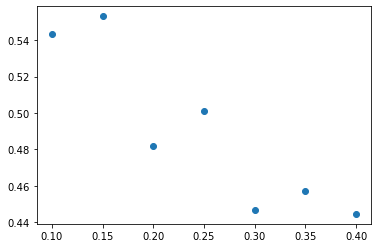

In [196]:
plt.xlabel("Test Data Size Relative To Total Data")
plt.ylabel("AUC")
plt.scatter(list(aucs.keys()), list(aucs.values()))

In [172]:
# x = catboost.CatBoostClassifier(cat_features=X_train.columns[1:])
x = xgboost.XGBClassifier()
x.fit(X_train, Y_train)

XGBClassifier()

In [175]:
from sklearn.metrics import roc_auc_score

# user_id_search = 405
# u = users.iloc[user_id_search-1]
# pred_x = pd.DataFrame({"sex": [u["sex"]], "occupation": [u["occupation"]], "age": [u["age"]]})
# pred_x["sex_F"] = 1 if u["sex"] == "F" else 0
# pred_x["sex_M"] = 1 if u["sex"] == "M" else 0
# for column in X_train.columns:
#     if "occupation" in column:
#         pred_x[column] = 1 if pred_x.iloc[0]["occupation"] in column else 0
# pred_x = pred_x.drop(["sex"], axis=1)
# pred_x = pred_x.drop(["occupation"], axis=1)

roc_auc_score(Y_test, x.predict_proba(X_test)[:, 1])
# roc_auc_score(Y_train, x.predict_proba(X_train)[:, 1])

0.4374304783092325

In [158]:
len(X_train)

453

In [151]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994


In [152]:
len(ratings)


100000

In [153]:
ratings

,user_id,movie_id,rating,unix_timestamp,imdb,Action,Adventure,Children,above,Action_above,Adventure_above,Children_above
59862,408,215,4.0,881107251,3.80,0,0,0,0,-1.0,-1.0,-1.0
12782,134,474,4.0,879857592,4.05,0,0,0,1,-1.0,-1.0,-1.0
56350,704,404,4.0,883427479,3.55,1,1,0,0,0.0,-1.0,0.0
48165,690,169,5.0,875543395,4.25,0,0,0,0,-1.0,-1.0,-1.0
74220,534,644,4.0,879617856,4.10,0,0,0,1,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19657,300,718,4.0,882079542,3.00,0,0,0,0,-1.0,-1.0,-1.0
52207,652,818,3.0,880149751,2.60,0,0,0,0,-1.0,-1.0,-1.0
819,243,182,4.0,880606043,4.20,1,0,0,1,1.0,-1.0,1.0
62167,867,1034,1.0,877107817,3.50,0,0,0,1,-1.0,-1.0,-1.0


In [26]:
len(users)

943

In [148]:
original_user_movies_df

,Timestamp,Toy Story (1995),Twelve Monkeys (1995),Star Wars (1977),Pulp Fiction (1994),"Silence of the Lambs, The (1991)",Fargo (1996),Independence Day (ID4) (1996),"Godfather, The (1972)",Raiders of the Lost Ark (1981),Return of the Jedi (1983),Contact (1997),"English Patient, The (1996)",Scream (1996),Liar Liar (1997),Air Force One (1997),"Out of all of the genres below, what are your top 3 favorites?",Unnamed: 17
0,2020/12/08 9:55:50 PM CST,5 - Loved it,2 - Didn't like it,4 - Liked it,1 - Hated it,Didn't watch,1 - Hated it,1 - Hated it,1 - Hated it,4 - Liked it,4 - Liked it,3 - Neutral,3 - Neutral,2 - Didn't like it,4 - Liked it,2 - Didn't like it,Animation;Children;Musical,4 - Liked it
